#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite Difference methods in 2 dimensions

Let's start by generalizing the 1D Laplacian,

\begin{align} - u''(x) &= f(x) \text{ on } \Omega = (a,b) & u(a) &= g_0(a) & u'(b) = g_1(b) \end{align}

to two dimensions

\begin{align} -\nabla\cdot \big( \nabla u(x,y) \big) &= f(x,y) \text{ on } \Omega \subset \mathbb R^2
& u|_{\Gamma_D} &= g_0(x,y) & \nabla u \cdot \hat n|_{\Gamma_N} &= g_1(x,y)
\end{align}

where $\Omega$ is some well-connected open set (we will assume simply connected) and the Dirichlet boundary $\Gamma_D \subset \partial \Omega$ is nonempty.

We need to choose a system for specifying the domain $\Omega$ and ordering degrees of freedom.  Perhaps the most significant limitation of finite difference methods is that this specification is messy for complicated domains.  We will choose
$$ \Omega = (0, 1) \times (0, 1) $$
and
\begin{align} (x, y)_{im+j} &= (i h, j h) & h &= 1/(m-1) & i,j \in \{0, 1, \dotsc, m-1 \} .
\end{align}

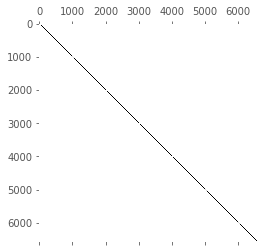

In [2]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def laplacian2d_dense(h, f, g0):
    m = int(1/h + 1)
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    A = numpy.zeros((m*m, m*m))
    
    
    def idx(i, j):
        return i*m + j
    
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            #check for boundary conditions
            if i in (0, m-1) or j in (0, m-1):
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                cols = [idx(*pair) for pair in
                        [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]]
                stencil = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
                A[row, cols] = stencil
    return x, y, A, rhs

x, y, A, rhs = laplacian2d_dense(.0125, lambda x,y: 0*x+1, lambda x,y: 0*x)
numpy.set_printoptions(threshold=numpy.nan)
pyplot.spy(A);

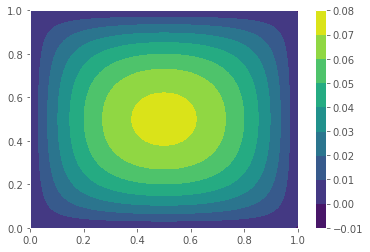

In [3]:
u = numpy.linalg.solve(A, rhs).reshape(x.shape)

pyplot.contourf(x, y, u)
pyplot.colorbar();

In [4]:
import cProfile
prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d_dense(.125, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = numpy.linalg.solve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         543 function calls in 0.041 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.038    0.038    0.039    0.039 <ipython-input-4-691c5190a0fc>:4(<module>)
        1    0.002    0.002    0.002    0.002 linalg.py:315(solve)
        1    0.001    0.001    0.001    0.001 <ipython-input-2-f3120e3c7202>:6(laplacian2d_dense)
        3    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
       59    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
       49    0.000    0.000    0.000    0.000 <ipython-input-2-f3120e3c7202>:26(<listcomp>)
      326    0.000    0.000    0.000    0.000 <ipython-input-2-f3120e3c7202>:15(idx)
        1    0.000    0.000    0.000    0.000 function_base.py:25(linspace)
        3    0.000    0.000    0.041    0.014 interactiveshell.py:2880(run_code)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.zeros}

0.0

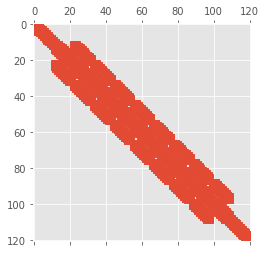

In [5]:
import scipy.sparse as sp
import scipy.sparse.linalg
'''
NOTE: Why don't we construct A without considering 
boundary conditions first, then replace the rows 

'''
def laplacian2d(h, f, g0):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    '''
    https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.lil_matrix.html:
    
    Note that inserting a single item can take linear time in the worst case; 
    to construct a matrix efficiently, make sure the items are pre-sorted 
    by index, per row.
    '''
    A = sp.lil_matrix((m*m, m*m))
    
    def idx(i, j):
        return i*m + j
    
    mask = numpy.zeros_like(x, dtype=int)
    mask[1:-1,1:-1] = 1
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in 
                                    [(i-1, j), (i, j-1),
                                     (i, j),
                                     (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])

            # Dirichlet boundary
            if mask[row] == 0: 
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                #extract the corresponding mask values using the stencil
                smask = mask[stencili]
                #use only non boundary values
                cols = stencili[smask == 1]
                #construct A for values that don't lie in the boundary
                A[row, cols] = stencilw[smask == 1]
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    return x, y, A.tocsr(), rhs

x, y, A, rhs = laplacian2d(.1, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);
sp.linalg.norm(A - A.T)

In [6]:
prof = cProfile.Profile()
#encase code in the enable and disable methods to time them
prof.enable()
x, y, A, rhs = laplacian2d(.125, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         7686 function calls in 0.026 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.017    0.017    0.017    0.017 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
        1    0.002    0.002    0.008    0.008 <ipython-input-5-e62598fbcb4a>:8(laplacian2d)
      198    0.001    0.000    0.001    0.000 stride_tricks.py:115(_broadcast_to)
      726    0.001    0.000    0.001    0.000 {built-in method numpy.core.multiarray.array}
       81    0.000    0.000    0.005    0.000 lil.py:333(__setitem__)
       49    0.000    0.000    0.000    0.000 {scipy.sparse._csparsetools.lil_fancy_set}
       99    0.000    0.000    0.002    0.000 stride_tricks.py:195(broadcast_arrays)
       98    0.000    0.000    0.000    0.000 sputils.py:331(_check_boolean)
       99    0.000    0.000    0.000    0.000 stride_tricks.py:176(_broadcast_shape)
       49    0.000    0.000    0.001    0.000 sputils.py:265(_unpack_index

## A manufactured solution

(51, 51) 1.1539730774973167e-06


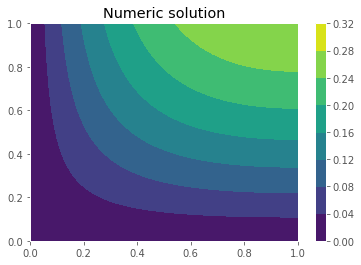

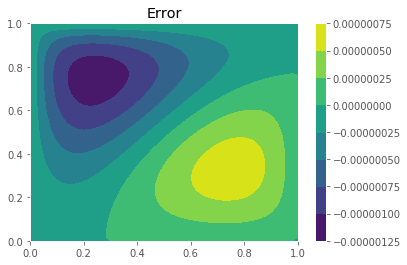

In [7]:
class mms0:
    def u(x, y):
        return x*numpy.exp(-x)*numpy.tanh(y)
    def grad_u(x, y):
        return numpy.array([(1 - x)*numpy.exp(-x)*numpy.tanh(y),
                            x*numpy.exp(-x)*(1 - numpy.tanh(y)**2)])
    def laplacian_u(x, y):
        return ((2 - x)*numpy.exp(-x)*numpy.tanh(y)
                - 2*x*numpy.exp(-x)*(numpy.tanh(y)**2 - 1)*numpy.tanh(y))
    def grad_u_dot_normal(x, y, n):
        return grad_u(x, y) @ n

x, y, A, rhs = laplacian2d(.02, mms0.laplacian_u, mms0.u)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
print(u.shape, numpy.linalg.norm((u - mms0.u(x,y)).flatten(), numpy.inf))
pyplot.contourf(x, y, u)
pyplot.colorbar()
pyplot.title('Numeric solution')
pyplot.figure()
pyplot.contourf(x, y, u - mms0.u(x, y))
pyplot.colorbar()
pyplot.title('Error');



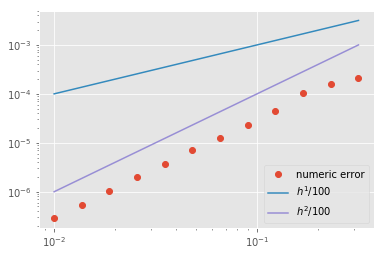

In [8]:
hs = numpy.logspace(-2, -.5, 12)
def mms_error(h):
    x, y, A, rhs = laplacian2d(h, mms0.laplacian_u, mms0.u)
    u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
    return numpy.linalg.norm((u - mms0.u(x, y)).flatten(), numpy.inf)

pyplot.loglog(hs, [mms_error(h) for h in hs], 'o', label='numeric error')
pyplot.loglog(hs, hs**1/100, label='$h^1/100$')
pyplot.loglog(hs, hs**2/100, label='$h^2/100$')
pyplot.legend();

# Neumann boundary conditions

Recall that in 1D, we would reflect the solution into ghost points according to

$$ u_{-i} = u_i - (x_i - x_{-i}) g_1(x_0, y) $$

and similarly for the right boundary and in the $y$ direction.  After this, we (optionally) scale the row in the matrix for symmetry and shift the known parts to the right hand side.  Below, we implement the reflected symmetry, but not the inhomogeneous contribution or rescaling of the matrix row.

[1.+0.0000000e+00j 1.+0.0000000e+00j 1.+0.0000000e+00j 1.+0.0000000e+00j
 1.+0.0000000e+00j 1.+3.7407911e-15j]


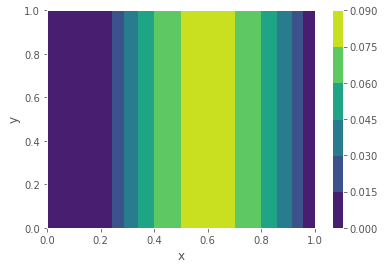

In [9]:
def laplacian2d_bc(h, f, g0, dirichlet=((),())):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    ai = []
    aj = []
    av = []
    #didn't know you could define a function within a function
    #could you define recusive functions within a recursive function?
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    
    mask = numpy.ones_like(x, dtype=int)
    #dirchlet is on the boundary of the grid (x_0, x_n), (y_0, y_n)
    mask[dirichlet[0],:] = 0
    mask[:,dirichlet[1]] = 0
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask == 1].tolist()
                av += stencilw[smask == 1].tolist()
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    A = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return x, y, A, rhs

#x, y, A, rhs = laplacian2d_bc(.15, lambda x,y: 0*x+1,lambda x,y: 0*x, dirichlet=((int((1/.15)),),()))
x, y, A, rhs = laplacian2d_bc(.1, lambda x,y: 0*x + 1,lambda x,y: 0*x, dirichlet=((0,2,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
print(sp.linalg.eigs(A, which='SM')[0])
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.contourf(x, y, u)
pyplot.colorbar();

In [10]:
# We used a different technique for assembling the sparse matrix.
# This is faster with scipy.sparse, but may be worse for other sparse matrix packages, such as PETSc.

prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d_bc(.005, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         1454879 function calls (1454877 primitive calls) in 1.217 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.517    0.517    0.998    0.998 <ipython-input-9-5d0dfbc19575>:1(laplacian2d_bc)
        1    0.212    0.212    0.212    0.212 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
   242406    0.162    0.000    0.218    0.000 <ipython-input-9-5d0dfbc19575>:13(idx)
    80839    0.125    0.000    0.125    0.000 {built-in method numpy.core.multiarray.array}
    40401    0.069    0.000    0.069    0.000 {built-in method builtins.sum}
   969624    0.056    0.000    0.056    0.000 {built-in method builtins.abs}
    40401    0.041    0.000    0.217    0.000 <ipython-input-9-5d0dfbc19575>:26(<listcomp>)
    80802    0.020    0.000    0.020    0.000 {method 'tolist' of 'numpy.ndarray' objects}
        1    0.007    0.007    1.005    1.005 <ipython-input-10-b5abe0e23855>:6(<module>)
        3    0.002

# Variable coefficients

In physical systems, it is common for equations to be given in **divergence form** (sometimes called **conservative form**),
$$ -\nabla\cdot \Big( \kappa(x,y) \nabla u \Big) = f(x,y) . $$
This can be converted to **non-divergence form**,
$$ - \kappa(x,y) \nabla\cdot \nabla u - \nabla \kappa(x,y) \cdot \nabla u = f(x,y) . $$

* What assumptions did we just make on $\kappa(x,y)$?

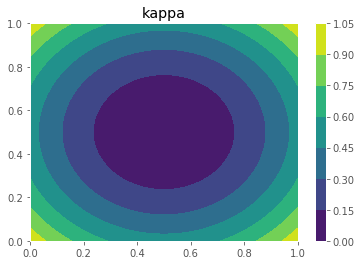

In [11]:
def laplacian2d_nondiv(h, f, kappa, grad_kappa, g0, dirichlet=((),())):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    
    
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    
    
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    
    ai = []
    aj = []
    av = []
    
    
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    
    
    mask = numpy.ones_like(x, dtype=int)
    #apply dirichlet conditions to the mask
    #i.e. zero out the boundaries
    mask[dirichlet[0],:] = 0
    mask[:,dirichlet[1]] = 0
    mask = mask.flatten()
    
    
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            # -k(x,y) * ∆u = stencilw (the negative is taken care of in the second else statement)
            stencilw = kappa(i*h, j*h)/h**2 * numpy.array([-1, -1, 4, -1, -1])
            
            if grad_kappa is None:
                gk = 1/h * numpy.array([kappa((i+.5)*h,j*h) - kappa((i-.5)*h,j*h),
                                        kappa(i*h,(j+.5)*h) - kappa(i*h,(j-.5)*h)])
            else:
                gk = grad_kappa(i*h, j*h)
            
            #stencilw - (grad_kappa(x,y)_x * stencil of u'(x,y)_x)
            #stencilw - (grad_kappa(x,y)_y * stencil of u'(x,y)_y)
            stencilw -= gk[0] / (2*h) * numpy.array([-1, 0, 0, 0, 1])
            stencilw -= gk[1] / (2*h) * numpy.array([0, -1, 0, 1, 0]) 
            
            
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask == 1].tolist()
                av += stencilw[smask == 1].tolist()
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
                
    A = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return x, y, A, rhs

def kappa(x, y):
    #return 1 - 2*(x-.5)**2 - 2*(y-.5)**2
    return 1e-2 + 2*(x-.5)**2 + 2*(y-.5)**2
def grad_kappa(x, y):
    #return -4*(x-.5), -4*(y-.5)
    return 4*(x-.5), 4*(y-.5)

pyplot.title('kappa')
pyplot.contourf(x, y, kappa(x,y))
pyplot.colorbar();

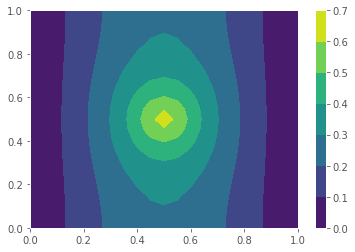

In [12]:
x, y, A, rhs = laplacian2d_nondiv(.05, lambda x,y: 0*x+1,
                                  kappa, grad_kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.colorbar();

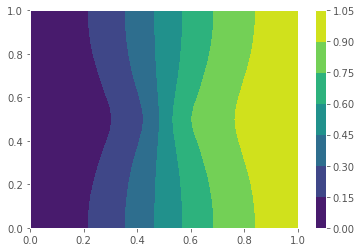

In [13]:
x, y, A, rhs = laplacian2d_nondiv(.05, lambda x,y: 0*x,
                                  kappa, grad_kappa,
                                  lambda x,y: x, dirichlet=((0,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.colorbar();

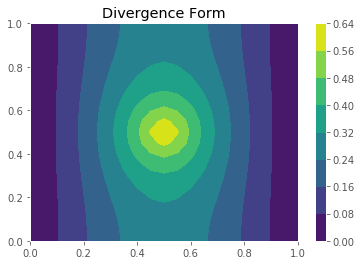

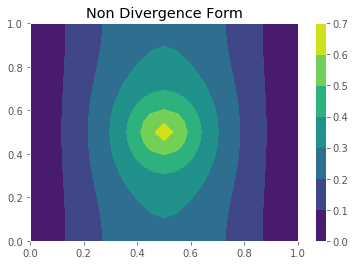

In [14]:
def laplacian2d_div(h, f, kappa, g0, dirichlet=((),())):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=int)
    mask[dirichlet[0],:] = 0
    mask[:,dirichlet[1]] = 0
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * (  kappa((i-.5)*h, j*h) * numpy.array([-1, 0, 1, 0, 0])
                                 + kappa(i*h, (j-.5)*h) * numpy.array([0, -1, 1, 0, 0])
                                 + kappa(i*h, (j+.5)*h) * numpy.array([0, 0, 1, -1, 0])
                                 + kappa((i+.5)*h, j*h) * numpy.array([0, 0, 1, 0, -1]))
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask == 1].tolist()
                av += stencilw[smask == 1].tolist()
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    A = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return x, y, A, rhs

x, y, A, rhs = laplacian2d_div(.05, lambda x,y: 0*x+1,
                                  kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u1 = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.figure()
pyplot.title('Divergence Form')
pyplot.contourf(x, y, u1)
pyplot.colorbar()

x,y,A,rhs = laplacian2d_nondiv(.05,lambda x,y: 0*x +1,
                               kappa, grad_kappa,
                               lambda x,y:0*x, dirichlet=((0,-1),()))
u2 = sp.linalg.spsolve(A,rhs).reshape(x.shape)
pyplot.figure()
pyplot.title('Non Divergence Form')
pyplot.contourf(x, y, u2)
pyplot.colorbar();

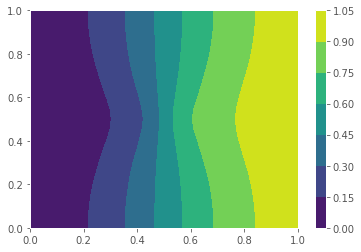

In [15]:
x, y, A, rhs = laplacian2d_div(.05, lambda x,y: 0*x,
                                  kappa,
                                  lambda x,y: x, dirichlet=((0,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.colorbar();

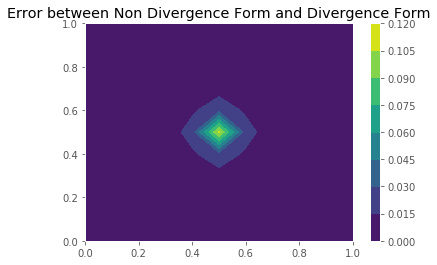

In [16]:
x, y, A, rhs = laplacian2d_nondiv(.1, lambda x,y: 0*x+1,
                                  kappa, grad_kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u_nondiv = sp.linalg.spsolve(A, rhs).reshape(x.shape)

x, y, A, rhs = laplacian2d_div(.1, lambda x,y: 0*x+1,
                                  kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u_div = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.title('Error between Non Divergence Form and Divergence Form')
pyplot.contourf(x, y, u_nondiv - u_div)
pyplot.colorbar();

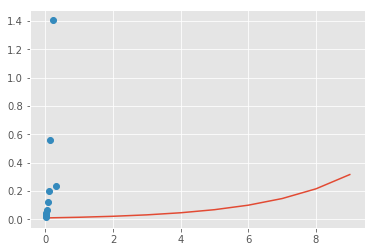

In [17]:
hs = numpy.logspace(-2,-.5,10)
errors = []
for h in hs:
    x, y, A, rhs = laplacian2d_nondiv(h, lambda x,y: 0*x+1,
                                      kappa, grad_kappa,
                                      lambda x,y: 0*x, dirichlet=((0,-1),()))
    u_nondiv = sp.linalg.spsolve(A, rhs).reshape(x.shape)

    x, y, A, rhs = laplacian2d_div(h, lambda x,y: 0*x+1,
                                      kappa,
                                      lambda x,y: 0*x, dirichlet=((0,-1),()))
    u_div = sp.linalg.spsolve(A, rhs).reshape(x.shape)
    errors.append(numpy.linalg.norm((u_nondiv - u_div), numpy.inf))
pyplot.plot(hs)
pyplot.plot(hs, errors, 'o')

0.00027462551190794715

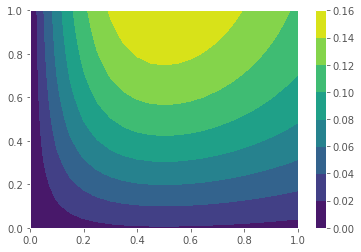

In [18]:
class mms1:
    def __init__(self):
        import sympy
        x, y = sympy.symbols('x y')
        uexpr = x*sympy.exp(-2*x) * sympy.tanh(1.2*y+.1)
        kexpr = 1e-2 + 2*(x-.42)**2 + 2*(y-.51)**2
        self.u = sympy.lambdify((x,y), uexpr)
        self.kappa = sympy.lambdify((x,y), kexpr)
        def grad_kappa(xx, yy):
            kx = sympy.lambdify((x,y), sympy.diff(kexpr, x))
            ky = sympy.lambdify((x,y), sympy.diff(kexpr, y))
            return kx(xx, yy), ky(xx, yy)
        self.grad_kappa = grad_kappa
        self.div_kappa_grad_u = sympy.lambdify((x,y),
                                              -(  sympy.diff(kexpr * sympy.diff(uexpr, x), x)
                                                + sympy.diff(kexpr * sympy.diff(uexpr, y), y)))
        
mms = mms1()
x, y, A, rhs = laplacian2d_nondiv(.05, mms.div_kappa_grad_u,
                                  mms.kappa, mms.grad_kappa,
                                  mms.u, dirichlet=((0,-1),(0,-1)))
u_nondiv = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u_nondiv)
pyplot.colorbar()
numpy.linalg.norm((u_nondiv - mms.u(x, y)).flatten(), numpy.inf)

0.0007198029643471771

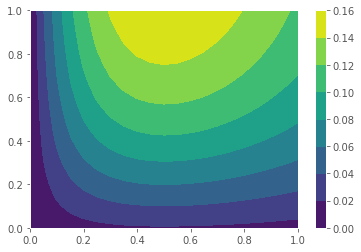

In [19]:
x, y, A, rhs = laplacian2d_div(.05, mms.div_kappa_grad_u,
                                  mms.kappa,
                                  mms.u, dirichlet=((0,-1),(0,-1)))
u_div = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u_div)
pyplot.colorbar()
numpy.linalg.norm((u_div - mms.u(x, y)).flatten(), numpy.inf)

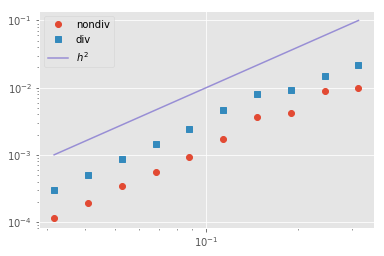

In [20]:
def mms_error(h):
    x, y, A, rhs = laplacian2d_nondiv(h, mms.div_kappa_grad_u,
                                  mms.kappa, mms.grad_kappa,
                                  mms.u, dirichlet=((0,-1),(0,-1)))
    u_nondiv = sp.linalg.spsolve(A, rhs).flatten()
    x, y, A, rhs = laplacian2d_div(h, mms.div_kappa_grad_u,
                                  mms.kappa, mms.u, dirichlet=((0,-1),(0,-1)))
    u_div = sp.linalg.spsolve(A, rhs).flatten()
    u_exact = mms.u(x, y).flatten()
    return numpy.linalg.norm(u_nondiv - u_exact, numpy.inf), numpy.linalg.norm(u_div - u_exact, numpy.inf)

hs = numpy.logspace(-1.5, -.5, 10)
errors = numpy.array([mms_error(h) for h in hs])
pyplot.loglog(hs, errors[:,0], 'o', label='nondiv')
pyplot.loglog(hs, errors[:,1], 's', label='div')
pyplot.plot(hs, hs**2, label='$h^2$')
pyplot.legend();

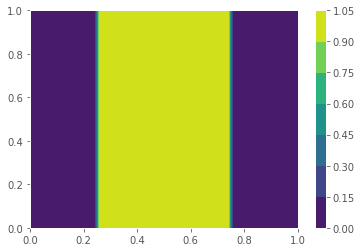

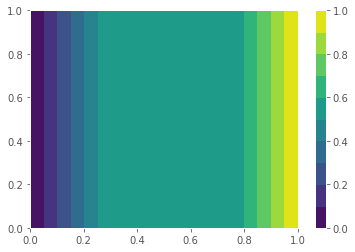

In [21]:
#kappablob = lambda x,y: .01 + ((x-.5)**2 + (y-.5)**2 < .125)
def kappablob(x, y):
    #return .01 + ((x-.5)**2 + (y-.5)**2 < .125)
    return .01 + (numpy.abs(x-.505) < .25) # + (numpy.abs(y-.5) < .25)
x, y, A, rhs = laplacian2d_div(.02, lambda x,y: 0*x, kappablob,
                                  lambda x,y:x, dirichlet=((0,-1),()))
u_div = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, kappablob(x, y))
pyplot.colorbar();
pyplot.figure()
pyplot.contourf(x, y, u_div, 10)
pyplot.colorbar();

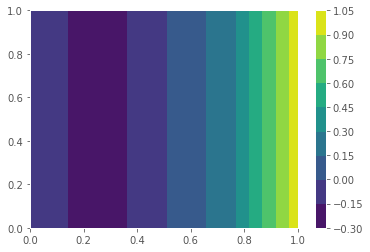

In [22]:
x, y, A, rhs = laplacian2d_nondiv(.05, lambda x,y: 0*x, kappablob, None,
                                  lambda x,y:x, dirichlet=((0,-1),()))
u_nondiv = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u_nondiv, 10)
pyplot.colorbar();

## Weak forms

When we write

$$ {\huge "} - \nabla\cdot \big( \kappa \nabla u \big) = 0 {\huge "} \text{ on } \Omega $$

where $\kappa$ is a discontinuous function, that's not exactly what we mean the derivative of that discontinuous function doesn't exist.  Formally, however, let us multiply by a "test function" $v$ and integrate,

\begin{split}
  - \int_\Omega v \nabla\cdot \big( \kappa \nabla u \big) = 0 & \text{ for all } v \\
  \int_\Omega \nabla v \cdot \kappa \nabla u = \int_{\partial \Omega} v \kappa \nabla u \cdot \hat n & \text{ for all } v
\end{split}

where we have used integration by parts.  This is called the **weak form** of the PDE and will be what we actually discretize using finite element methods.  All the terms make sense when $\kappa$ is discontinuous.  Now suppose our domain is decomposed into two disjoint sub domains $$\overline{\Omega_1 \cup \Omega_2} = \overline\Omega $$
with interface $$\Gamma = \overline\Omega_1 \cap \overline\Omega_2$$ and $\kappa_1$ is continuous on $\overline\Omega_1$ and $\kappa_2$ is continuous on $\overline\Omega_2$, but possibly $\kappa_1(x) \ne \kappa_2(x)$ for $x \in \Gamma$,

\begin{split}
\int_\Omega \nabla v \cdot \kappa \nabla u &= \int_{\Omega_1} \nabla v \cdot \kappa_1\nabla u + \int_{\Omega_2} \nabla v \cdot \kappa_2 \nabla u \\
&= -\int_{\Omega_1} v \nabla\cdot \big(\kappa_1 \nabla u \big) + \int_{\partial \Omega_1} v \kappa_1 \nabla u \cdot \hat n \\
&\qquad -\int_{\Omega_2} v \nabla\cdot \big(\kappa_2 \nabla u \big) + \int_{\partial \Omega_2} v \kappa_2 \nabla u \cdot \hat n \\
&= -\int_{\Omega} v \nabla\cdot \big(\kappa \nabla u \big) + \int_{\partial \Omega} v \kappa \nabla u \cdot \hat n + \int_{\Gamma} v (\kappa_1 - \kappa_2) \nabla u\cdot \hat n .
\end{split}

* Which direction is $\hat n$ for the integral over $\Gamma$?
* Does it matter what we choose for the value of $\kappa$ on $\Gamma$ in the volume integral?

When $\kappa$ is continuous, the jump term vanishes and we recover the **strong form**
$$ - \nabla\cdot \big( \kappa \nabla u \big) = 0 \text{ on } \Omega . $$
But if $\kappa$ is discontinuous, we would need to augment this with a jump condition ensuring that the flux $-\kappa \nabla u$ is continuous.  We could go add this condition to our FD code to recover convergence in case of discontinuous $\kappa$, but it is messy.

## Nonlinear problems

Let's consider the nonlinear problem
$$ -\nabla \cdot \big(\underbrace{(1 + u^2)}_{\kappa(u)} \nabla u \big) = f \text{ on } (0,1)^2 $$
subject to Dirichlet boundary conditions.  We will discretize the divergence form and thus will need
$\kappa(u)$ evaluated at staggered points $(i-1/2,j)$, $(i,j-1/2)$, etc.  We will calculate these by averaging
$$ u_{i-1/2,j} = \frac{u_{i-1,j} + u_{i,j}}{2} $$
and similarly for the other staggered directions.
To use a Newton method, we also need the derivatives
$$ \frac{\partial \kappa_{i-1/2,j}}{\partial u_{i,j}} = 2 u_{i-1/2,j} \frac{\partial u_{i-1/2,j}}{\partial u_{i,j}} = u_{i-1/2,j} . $$

In the function below, we compute both the residual
$$F(u) = -\nabla\cdot \kappa(u) \nabla u - f(x,y)$$
and its Jacobian
$$J(u) = \frac{\partial F}{\partial u} . $$

In [1]:
def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def nonlinear2d_div(h, x, y, u, forcing, g0, dirichlet=((),())):
    m = x.shape[0]
    u0 = g0(x, y).flatten()
    F = -forcing(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            # Stencil to evaluate gradient at four staggered points
            grad = numpy.array([[-1, 0, 1, 0, 0],
                                [0, -1, 1, 0, 0],
                                [0, 0, -1, 1, 0],
                                [0, 0, -1, 0, 1]]) / h
            # Stencil to average at four staggered points
            #the average stencil will give the staggered u values (i.e. u_{i+1/2,j})
            avg  = numpy.array([[1, 0, 1, 0, 0],
                                [0, 1, 1, 0, 0],
                                [0, 0, 1, 1, 0],
                                [0, 0, 1, 0, 1]]) / 2
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            ustag = avg @ ustencil
            kappa = 1 + ustag**2
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad + 2*(ustag*(grad @ ustencil))[:,None] * avg)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()
    J = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

h = .1
x, y = hgrid(h)
#initial guess
u = 0*x
F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
deltau = sp.linalg.spsolve(J, -F).reshape(x.shape)
pyplot.contourf(x, y, deltau)
pyplot.colorbar();

NameError: name 'numpy' is not defined

 0: anorm 1.000000e+00
 1: anorm 5.162198e-03
 2: anorm 1.035113e-07
 3: anorm 3.774758e-15


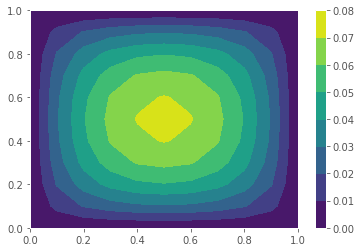

In [36]:
def solve_nonlinear(h, g0, dirichlet, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    for i in range(50):
        F, J = nonlinear2d_div(h, x, y, u, lambda x,y: 0*x+1,
                               lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)))
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        #solve for delta u
        deltau = sp.linalg.spsolve(J, -F)
        #update u based on delta u
        u += deltau.reshape(x.shape)
    return x, y, u, i

x, y, u, i = solve_nonlinear(.1, lambda x,y: 0*x, dirichlet=((0,-1),(0,-1)), verbose=True)
pyplot.contourf(x, y, u)
pyplot.colorbar();

## Homework 3: Due 2017-11-03

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics. Study how convergence is affected based on small values of $\epsilon$

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method. (choose h to be around $10^{-8}$)

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

# Wave equations and multi-component systems

The acoustic wave equation with constant wave speed $c$ can be written
$$ \ddot u - c^2 \nabla\cdot \nabla u = 0 $$
where $u$ is typically a pressure.
We can convert to a first order system
$$ \begin{bmatrix} \dot u \\ \dot v \end{bmatrix} = \begin{bmatrix} 0 & I \\ c^2 \nabla\cdot \nabla & 0 \end{bmatrix} \begin{bmatrix} u \\ v \end{bmatrix} . $$
We will choose a zero-penetration boundary condition $\nabla u \cdot \hat n = 0$, which will cause waves to reflect.

[ 2.25404764e-13+56.56854249j  2.25404764e-13-56.56854249j
 -2.94321425e-13+56.39416056j -2.94321425e-13-56.39416056j
 -3.47595216e-12+56.48141882j -3.47595216e-12-56.48141882j
  2.52440777e-12+56.48141882j  2.52440777e-12-56.48141882j
  2.12623582e-12+56.22139462j  2.12623582e-12-56.22139462j]


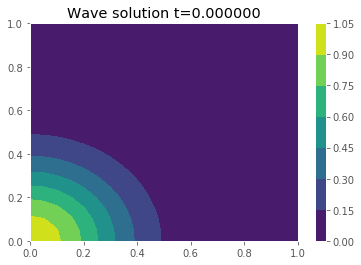

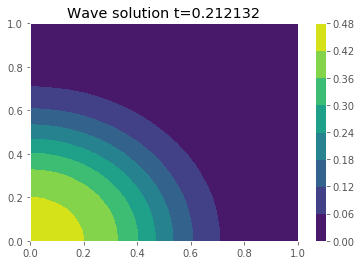

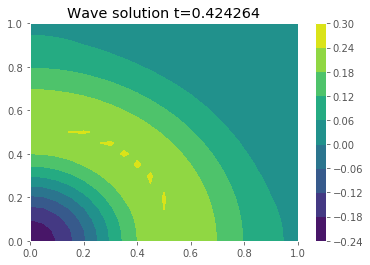

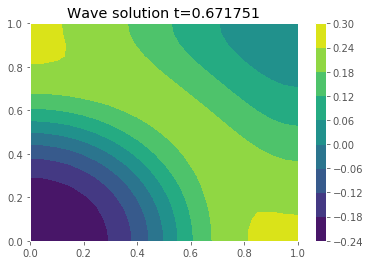

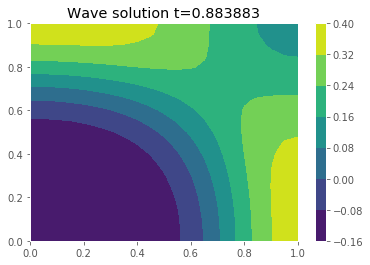

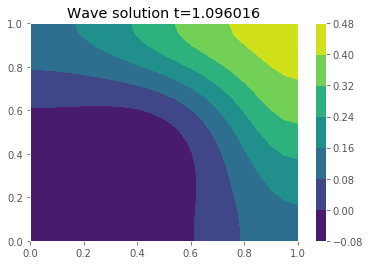

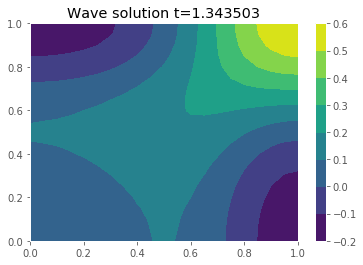

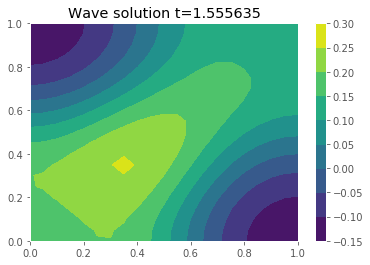

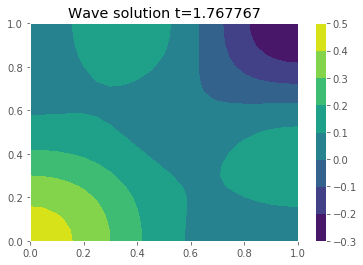

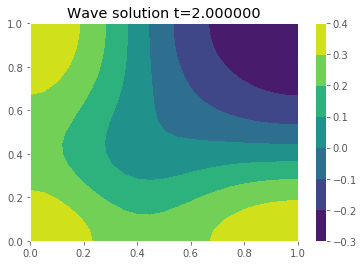

In [146]:
%run fdtools.py

x, y, L, _ = laplacian2d_bc(.05, lambda x,y: 0*x,
                              lambda x,y: 0*x, dirichlet=((),()))
A = sp.bmat([[None, sp.eye(*L.shape)],
             [-L, None]])
eigs = sp.linalg.eigs(A, 10, which='LM')[0]
print(eigs)
maxeig = max(eigs.imag)
u0 = numpy.concatenate([numpy.exp(-8*(x**2 + y**2)), 0*x], axis=None)
hist = ode_rkexplicit(lambda t, u: A @ u, u0, tfinal=2, h=2/maxeig)

def plot_wave(x, y, time, U):
    u = U[:x.size].reshape(x.shape)
    pyplot.contourf(x, y, u)
    pyplot.colorbar()
    pyplot.title('Wave solution t={:f}'.format(time));

for step in numpy.linspace(0, len(hist)-1, 10, dtype=int):
    pyplot.figure()
    plot_wave(x, y, *hist[step])

* This was a second order discretization, but we could extend it to higher order.
* The largest eigenvalues of this operator are proportional to $c/h$.
* Formally, we can write this equation in conservative form
$$ \begin{bmatrix} \dot u \\ \dot{\mathbf v} \end{bmatrix} = \begin{bmatrix} 0 & c\nabla\cdot \\ c \nabla & 0 \end{bmatrix} \begin{bmatrix} u \\ \mathbf v \end{bmatrix} $$
where $\mathbf{v}$ is now a momentum vector and $\nabla u = \nabla\cdot (u I)$.  This formulation could produce an anti-symmetric ($A^T = -A$) discretization.  Discretizations with this property are sometimes called "mimetic".
* A conservative form is often preferred when studiying waves traveling through materials with different wave speeds $c$.
* This is a Hamiltonian system.  While high order Runge-Kutta methods can be quite accurate, "symplectic" time integrators are needed to preserve the structure of the Hamiltonian (related to energy conservation) over long periods of time. The midpoint method (aka $\theta=1/2$) is one such method.  There are also explicit symplectic methods such as [Verlet methods](https://en.wikipedia.org/wiki/Verlet_integration), though these can be fragile.